In [1]:
# System Libraries
import os
import time
import warnings
warnings.filterwarnings("ignore")

# Data Handling Tools
import seaborn as sns
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D

# Google Drive Mount (Colab specific)
from google.colab import drive





# System Libraries
import os
import time
import warnings
warnings.filterwarnings("ignore")

# Data Handling Tools
import seaborn as sns
import cv2
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
from skimage import exposure
from skimage.feature import hog
from collections import Counter

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D

# Google Drive Mount (Colab specific)


In [2]:

class EyeDiseaseDataset:
    def __init__(self, dataDir, convert_to_grayscale=False):
        self.data_dir = dataDir
        self.convert_to_grayscale = convert_to_grayscale
        self.grayscale_dir = os.path.join(dataDir, 'grayscale') if convert_to_grayscale else None

        if convert_to_grayscale:
            os.makedirs(self.grayscale_dir, exist_ok=True)
            self._convert_to_grayscale()

    def _convert_to_grayscale(self):
        """Convert all images to grayscale and save in separate directory"""
        print("Converting images to grayscale...")
        folds = os.listdir(self.data_dir)
        for fold in folds:
            if fold == 'grayscale':
                continue

            fold_path = os.path.join(self.data_dir, fold)
            output_fold = os.path.join(self.grayscale_dir, fold)
            os.makedirs(output_fold, exist_ok=True)

            for file in os.listdir(fold_path):
                try:
                    img_path = os.path.join(fold_path, file)
                    img = Image.open(img_path).convert('L')  # Convert to grayscale
                    img.save(os.path.join(output_fold, file))
                except Exception as e:
                    print(f"Error processing {file}: {e}")
        print("Grayscale conversion complete.")

    def dataPaths(self):
        """Get file paths and labels"""
        filepaths = []
        labels = []

        target_dir = self.grayscale_dir if self.convert_to_grayscale else self.data_dir
        folds = os.listdir(target_dir)

        for fold in folds:
            foldPath = os.path.join(target_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels

    def dataFrame(self, files, labels):
        """Create DataFrame from file paths and labels"""
        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)

    def split_(self):
        """Split data into train, validation, and test sets"""
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)

        # Perform stratified split
        strat = df['labels']
        trainData, dummyData = train_test_split(
            df, train_size=0.8, shuffle=True,
            random_state=42, stratify=strat
        )

        strat = dummyData['labels']
        validData, testData = train_test_split(
            dummyData, train_size=0.5, shuffle=True,
            random_state=42, stratify=strat
        )

        return trainData, validData, testData

    def visualize_samples(self, num_samples=5):
        """Visualize sample images from each class"""
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)

        unique_classes = df['labels'].unique()
        plt.figure(figsize=(15, 8))

        for i, class_name in enumerate(unique_classes):
            class_samples = df[df['labels'] == class_name].sample(num_samples)

            for j, (_, row) in enumerate(class_samples.iterrows()):
                plt.subplot(len(unique_classes), num_samples, i * num_samples + j + 1)
                img = Image.open(row['filepaths'])

                if self.convert_to_grayscale:
                    plt.imshow(img, cmap='gray')
                else:
                    plt.imshow(img)

                plt.title(f"{class_name}\n{img.size}")
                plt.axis('off')

        plt.tight_layout()
        plt.show()

    def analyze_distribution(self):
        """Analyze class distribution in the dataset"""
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)

        plt.figure(figsize=(10, 5))
        ax = sns.countplot(data=df, x='labels')
        plt.title('Class Distribution')
        plt.xticks(rotation=45)

        # Add count labels to bars
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 5),
                        textcoords='offset points')

        plt.show()



Mounted at /content/drive
Converting images to grayscale...
Error processing cataract: [Errno 21] Is a directory: '/content/drive/MyDrive/dataset/enhanced/cataract'
Error processing diabetic_retinopathy: [Errno 21] Is a directory: '/content/drive/MyDrive/dataset/enhanced/diabetic_retinopathy'
Error processing normal: [Errno 21] Is a directory: '/content/drive/MyDrive/dataset/enhanced/normal'
Error processing glaucoma: [Errno 21] Is a directory: '/content/drive/MyDrive/dataset/enhanced/glaucoma'
Grayscale conversion complete.

Sample Images:


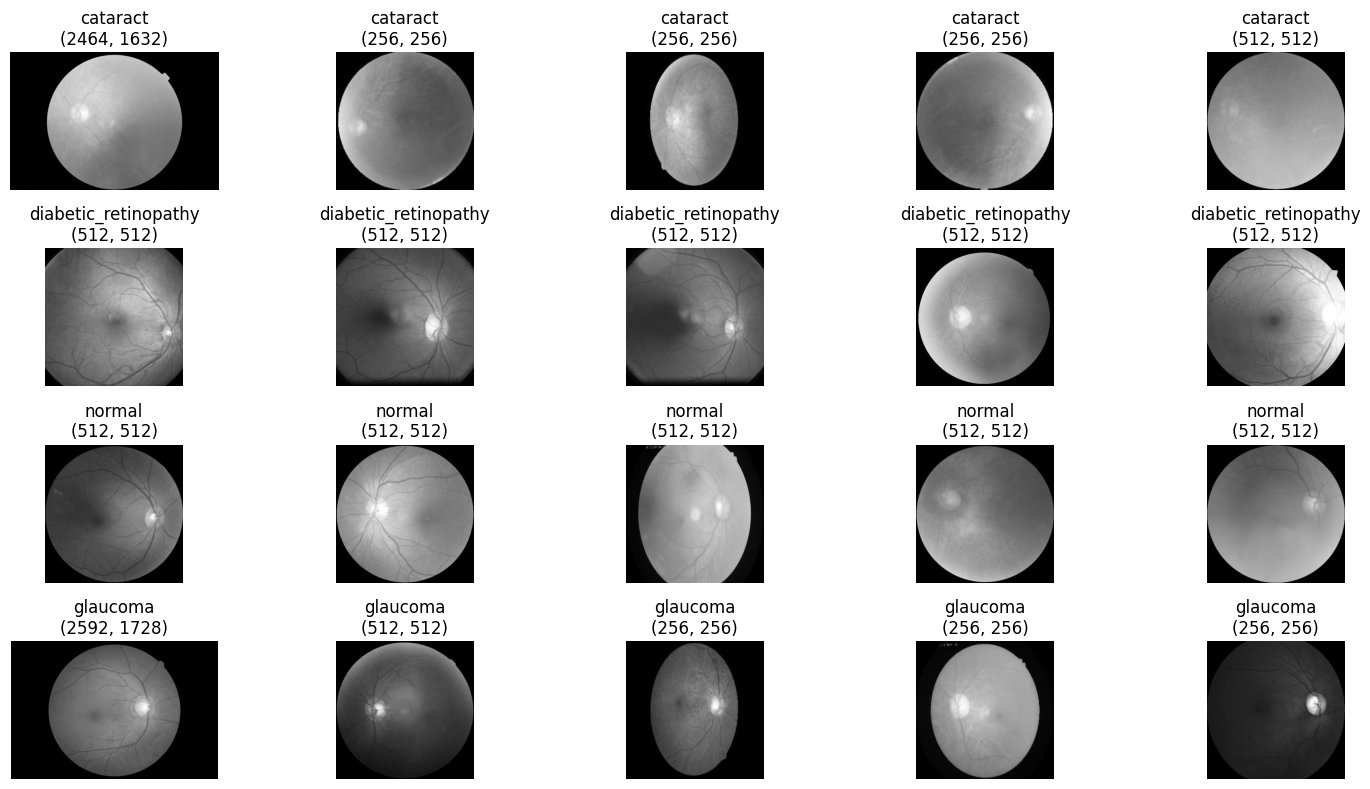


Class Distribution:


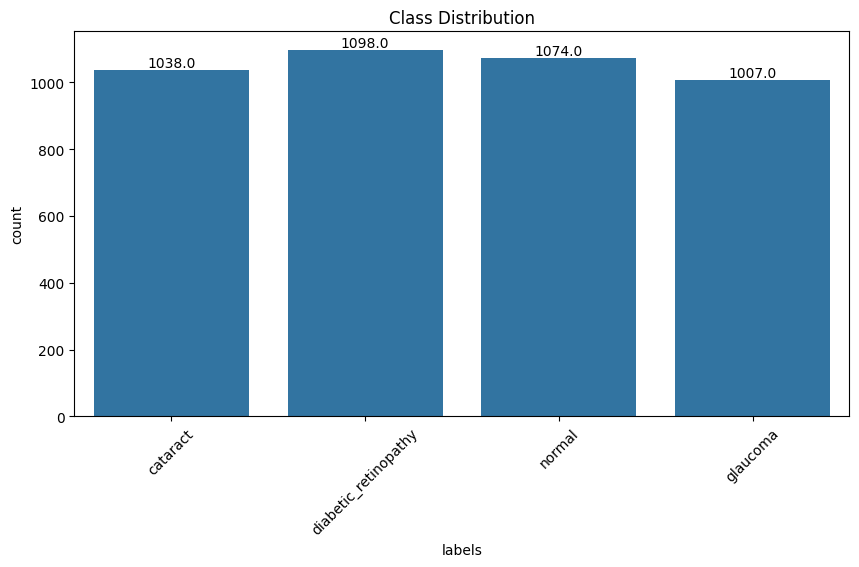


Training samples: 3373
Validation samples: 422
Test samples: 422


In [4]:
# Mount Google Drive
drive.mount('/content/drive')

# Initialize dataset with grayscale conversion
dataDir = '/content/drive/MyDrive/dataset'
dataSplit = EyeDiseaseDataset(dataDir, convert_to_grayscale=True)

# Split data
train_data, valid_data, test_data = dataSplit.split_()

# Visualize data
print("\nSample Images:")
dataSplit.visualize_samples()

print("\nClass Distribution:")
dataSplit.analyze_distribution()

# Display dataset sizes
print(f"\nTraining samples: {len(train_data)}")
print(f"Validation samples: {len(valid_data)}")
print(f"Test samples: {len(test_data)}")

In [5]:

from google.colab import drive

class AdvancedEyeDiseaseAnalysis:
    def __init__(self, dataDir, convert_to_grayscale=False, enhance_images=False):
        self.data_dir = dataDir
        self.convert_to_grayscale = convert_to_grayscale
        self.enhance_images = enhance_images
        self.grayscale_dir = os.path.join(dataDir, 'grayscale') if convert_to_grayscale else None
        self.enhanced_dir = os.path.join(dataDir, 'enhanced') if enhance_images else None

        if convert_to_grayscale:
            os.makedirs(self.grayscale_dir, exist_ok=True)
            self._convert_to_grayscale()

        if enhance_images:
            os.makedirs(self.enhanced_dir, exist_ok=True)
            self._enhance_images()

    def _convert_to_grayscale(self):
        """Convert all images to grayscale with enhanced contrast"""
        print("Converting images to grayscale with contrast enhancement...")
        folds = os.listdir(self.data_dir)
        for fold in folds:
            if fold in ['grayscale', 'enhanced']:
                continue

            fold_path = os.path.join(self.data_dir, fold)
            output_fold = os.path.join(self.grayscale_dir, fold)
            os.makedirs(output_fold, exist_ok=True)

            for file in os.listdir(fold_path):
                try:
                    img_path = os.path.join(fold_path, file)
                    img = Image.open(img_path)

                    # Convert to grayscale with contrast enhancement
                    gray_img = img.convert('L')
                    enhancer = ImageEnhance.Contrast(gray_img)
                    enhanced_img = enhancer.enhance(1.5)  # Increase contrast by 50%

                    enhanced_img.save(os.path.join(output_fold, file))
                except Exception as e:
                    print(f"Error processing {file}: {e}")
        print("Grayscale conversion complete.")

    def _enhance_images(self):
        """Apply advanced image enhancement techniques"""
        print("Applying image enhancement...")
        target_dir = self.grayscale_dir if self.convert_to_grayscale else self.data_dir
        folds = os.listdir(target_dir)

        for fold in folds:
            if fold in ['grayscale', 'enhanced']:
                continue

            fold_path = os.path.join(target_dir, fold)
            output_fold = os.path.join(self.enhanced_dir, fold)
            os.makedirs(output_fold, exist_ok=True)

            for file in os.listdir(fold_path):
                try:
                    img_path = os.path.join(fold_path, file)
                    img = cv2.imread(img_path)

                    if img is None:
                        continue

                    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
                    if len(img.shape) == 3:
                        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
                        l, a, b = cv2.split(lab)
                        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
                        cl = clahe.apply(l)
                        enhanced_lab = cv2.merge((cl, a, b))
                        enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
                    else:
                        enhanced_img = clahe.apply(img)

                    cv2.imwrite(os.path.join(output_fold, file), enhanced_img)
                except Exception as e:
                    print(f"Error enhancing {file}: {e}")
        print("Image enhancement complete.")

    def _extract_features(self, img_path):
        """Extract advanced image features for analysis"""
        img = cv2.imread(img_path)
        if img is None:
            return None

        features = {}

        # Basic features
        features['size'] = img.shape[:2]
        features['aspect_ratio'] = img.shape[1] / img.shape[0]

        # Color features (for RGB images)
        if len(img.shape) == 3:
            features['mean_r'] = np.mean(img[:,:,0])
            features['mean_g'] = np.mean(img[:,:,1])
            features['mean_b'] = np.mean(img[:,:,2])
            features['std_r'] = np.std(img[:,:,0])
            features['std_g'] = np.std(img[:,:,1])
            features['std_b'] = np.std(img[:,:,2])

        # Texture features using HOG
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img

        fd, hog_image = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                           cells_per_block=(1, 1), visualize=True)
        features['hog_mean'] = np.mean(fd)
        features['hog_std'] = np.std(fd)

        # Edge features
        edges = cv2.Canny(gray, 100, 200)
        features['edge_density'] = np.mean(edges)

        return features

    def dataPaths(self):
        """Get file paths and labels with feature extraction"""
        filepaths = []
        labels = []
        features = []

        target_dir = self.enhanced_dir if self.enhance_images else (
            self.grayscale_dir if self.convert_to_grayscale else self.data_dir
        )
        folds = os.listdir(target_dir)

        for fold in folds:
            if fold in ['grayscale', 'enhanced']:
                continue

            foldPath = os.path.join(target_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)

                # Extract features for EDA
                img_features = self._extract_features(fpath)
                if img_features:
                    img_features['label'] = fold
                    features.append(img_features)

        self.feature_df = pd.DataFrame(features)
        return filepaths, labels

    def dataFrame(self, files, labels):
        """Create DataFrame from file paths and labels"""
        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)

    def split_(self):
        """Split data into train, validation, and test sets"""
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)

        # Perform stratified split
        strat = df['labels']
        trainData, dummyData = train_test_split(
            df, train_size=0.8, shuffle=True,
            random_state=42, stratify=strat
        )

        strat = dummyData['labels']
        validData, testData = train_test_split(
            dummyData, train_size=0.5, shuffle=True,
            random_state=42, stratify=strat
        )

        return trainData, validData, testData

    def visualize_samples(self, num_samples=5):
        """Enhanced visualization with before/after comparison"""
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)

        unique_classes = df['labels'].unique()
        plt.figure(figsize=(20, 12))

        for i, class_name in enumerate(unique_classes):
            class_samples = df[df['labels'] == class_name].sample(num_samples)

            for j, (_, row) in enumerate(class_samples.iterrows()):
                # Original image
                orig_path = row['filepaths'].replace('enhanced', '').replace('grayscale', '')
                orig_path = os.path.join(self.data_dir, orig_path.split(self.data_dir)[-1].lstrip('/'))

                plt.subplot(len(unique_classes), num_samples*2, i * num_samples*2 + 2*j + 1)
                try:
                    orig_img = Image.open(orig_path)
                    plt.imshow(orig_img)
                    plt.title(f"Original\n{orig_img.size}")
                    plt.axis('off')
                except:
                    plt.text(0.5, 0.5, "Original\nNot Available", ha='center')
                    plt.axis('off')

                # Processed image
                plt.subplot(len(unique_classes), num_samples*2, i * num_samples*2 + 2*j + 2)
                proc_img = Image.open(row['filepaths'])

                if self.convert_to_grayscale:
                    plt.imshow(proc_img, cmap='gray')
                else:
                    plt.imshow(proc_img)

                plt.title(f"Processed\n{proc_img.size}")
                plt.axis('off')

        plt.suptitle("Image Preprocessing Comparison\n(Original vs Processed)", y=1.02)
        plt.tight_layout()
        plt.show()

    def analyze_distribution(self):
        """Advanced distribution analysis with multiple visualizations"""
        plt.figure(figsize=(20, 15))

        # Class distribution
        plt.subplot(2, 2, 1)
        ax = sns.countplot(data=self.feature_df, x='label')
        plt.title('Class Distribution')
        plt.xticks(rotation=45)
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 5),
                       textcoords='offset points')

        # Image size distribution
        plt.subplot(2, 2, 2)
        sizes = self.feature_df['size'].apply(lambda x: f"{x[0]}×{x[1]}")
        size_counts = sizes.value_counts().head(10)
        sns.barplot(x=size_counts.index, y=size_counts.values)
        plt.title('Top 10 Image Sizes')
        plt.xticks(rotation=45)

        # Color distribution (if RGB)
        if 'mean_r' in self.feature_df.columns:
            plt.subplot(2, 2, 3)
            sns.boxplot(data=self.feature_df[['mean_r', 'mean_g', 'mean_b']])
            plt.title('Channel-wise Color Distribution')

            plt.subplot(2, 2, 4)
            for label in self.feature_df['label'].unique():
                subset = self.feature_df[self.feature_df['label'] == label]
                plt.scatter(subset['mean_r'], subset['mean_g'], label=label, alpha=0.6)
            plt.xlabel('Mean Red')
            plt.ylabel('Mean Green')
            plt.title('Red-Green Color Space by Class')
            plt.legend()

        plt.tight_layout()
        plt.show()

        # Additional feature analysis
        if hasattr(self, 'feature_df'):
            self._analyze_texture_features()

    def _analyze_texture_features(self):
        """Analyze texture features using HOG"""
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        sns.boxplot(data=self.feature_df, x='label', y='hog_mean')
        plt.title('HOG Mean by Class')
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        sns.scatterplot(data=self.feature_df, x='hog_mean', y='edge_density', hue='label')
        plt.title('Texture vs Edge Density')

        plt.tight_layout()
        plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Converting images to grayscale with contrast enhancement...
Grayscale conversion complete.
Applying image enhancement...
Image enhancement complete.

Image Preprocessing Comparison:


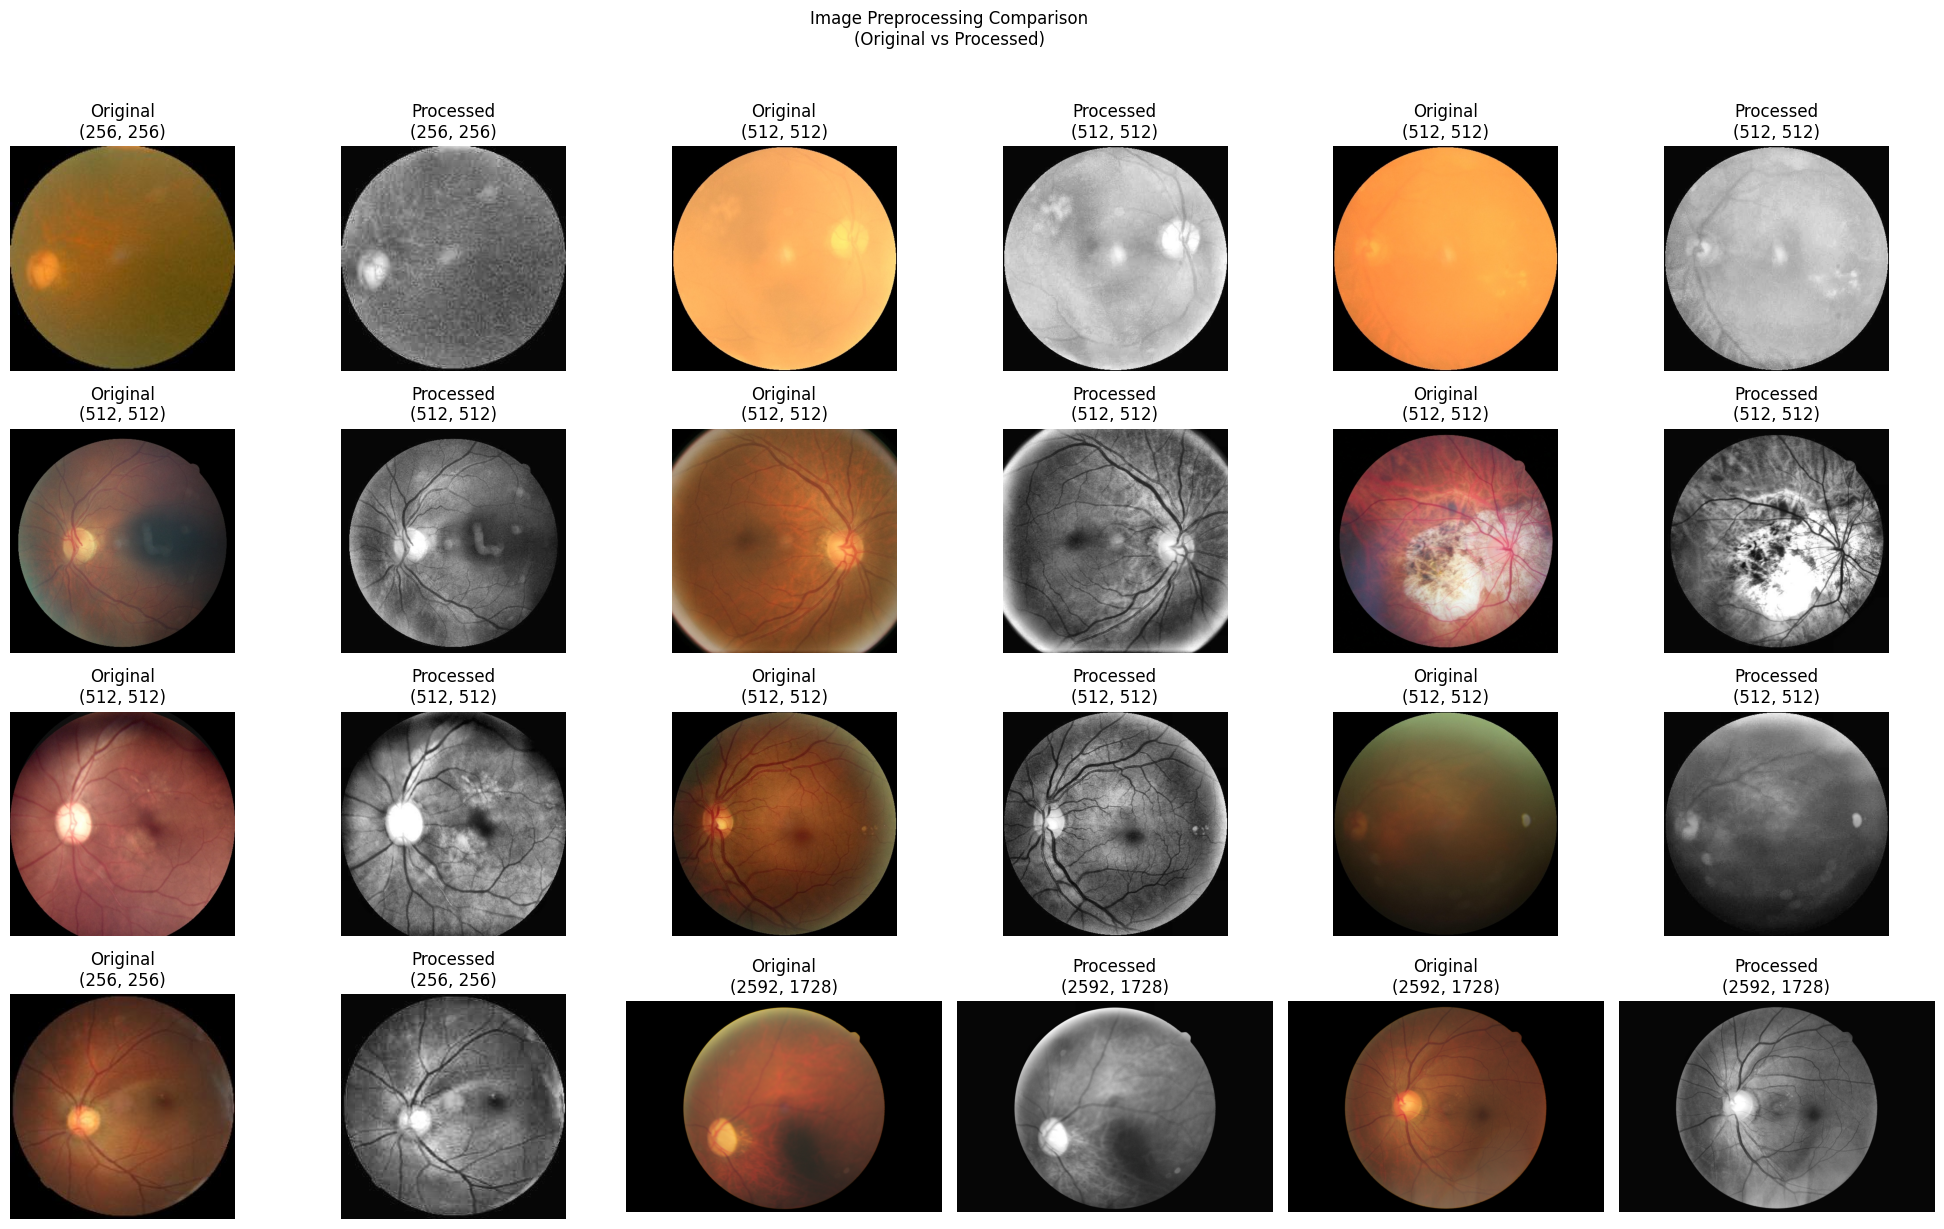


Advanced Dataset Analysis:


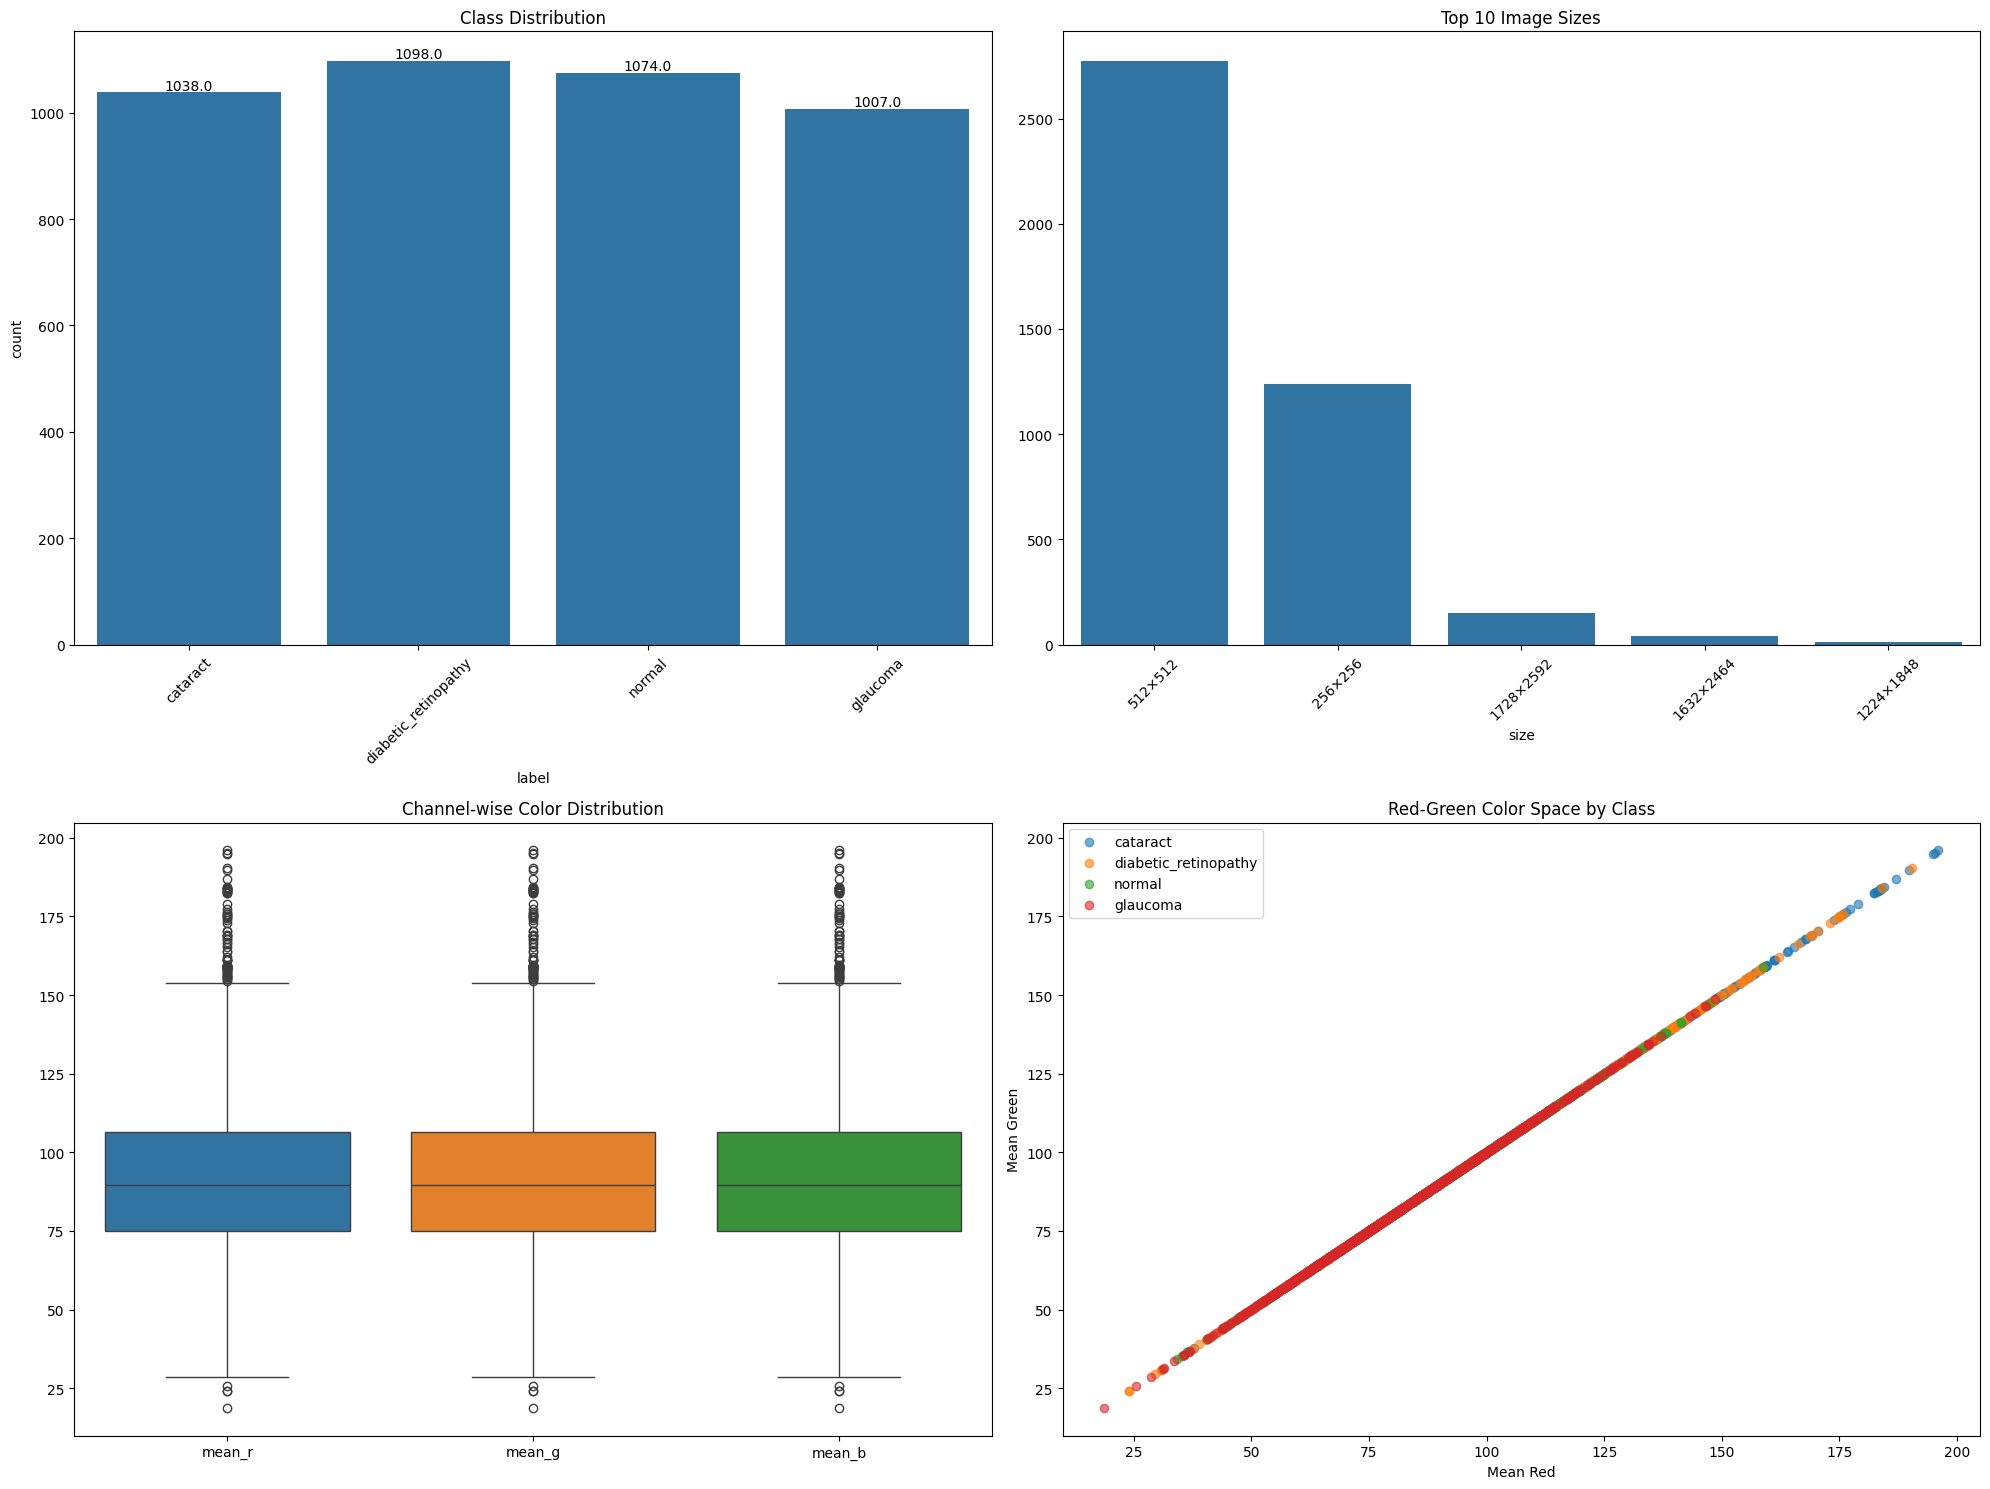

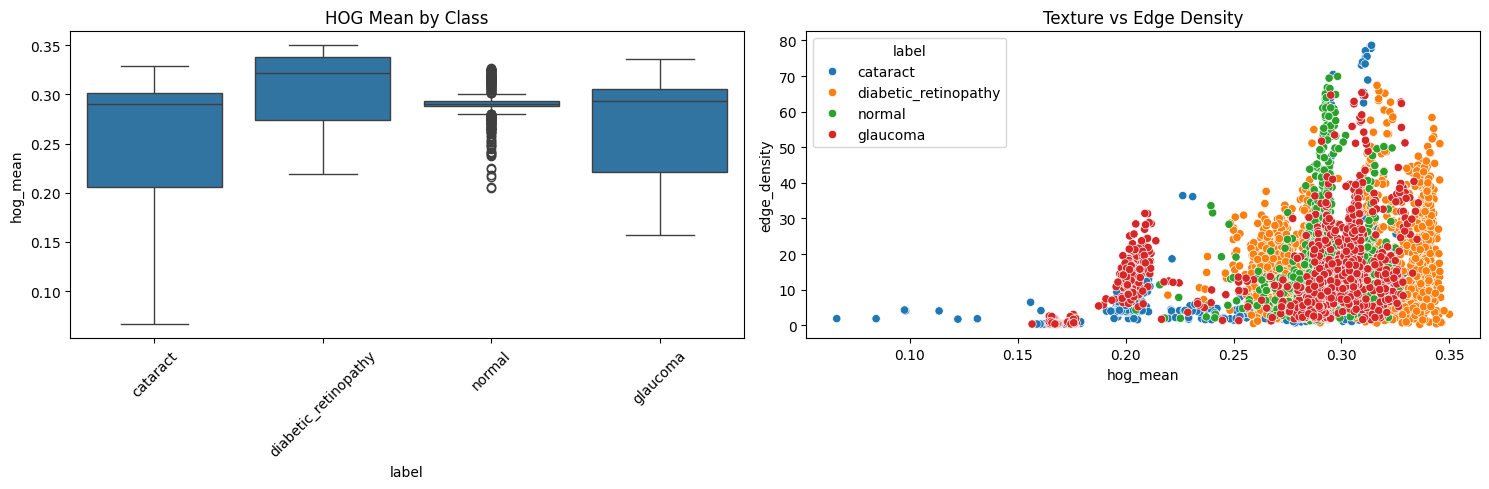


Dataset Statistics:
Training samples: 3373
Validation samples: 422
Test samples: 422

Feature Statistics:
       aspect_ratio       mean_r       mean_g       mean_b        std_r  \
count   4217.000000  4217.000000  4217.000000  4217.000000  4217.000000   
mean       1.023951    92.058326    92.059798    92.059252    56.725483   
std        0.107074    24.427750    24.426994    24.427502    13.411596   
min        1.000000    18.731647    18.731647    18.731647    13.813323   
25%        1.000000    74.967937    74.968670    74.967205    47.705339   
50%        1.000000    89.700737    89.700737    89.700737    55.568103   
75%        1.000000   106.599297   106.599663   106.599663    65.189170   
max        1.509804   196.007744   196.007744   196.007744   110.761061   

             std_g        std_b     hog_mean      hog_std  edge_density  
count  4217.000000  4217.000000  4217.000000  4217.000000   4217.000000  
mean     56.726654    56.726439     0.284480     0.148944     15.3834

In [6]:

# Mount Google Drive
drive.mount('/content/drive')

# Initialize dataset with advanced processing
dataDir = '/content/drive/MyDrive/dataset'
dataAnalyzer = AdvancedEyeDiseaseAnalysis(
    dataDir,
    convert_to_grayscale=True,
    enhance_images=True
)

# Split data
train_data, valid_data, test_data = dataAnalyzer.split_()

# Enhanced Visualizations
print("\nImage Preprocessing Comparison:")
dataAnalyzer.visualize_samples(num_samples=3)

print("\nAdvanced Dataset Analysis:")
dataAnalyzer.analyze_distribution()

# Display dataset statistics
print("\nDataset Statistics:")
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(valid_data)}")
print(f"Test samples: {len(test_data)}")
print("\nFeature Statistics:")
print(dataAnalyzer.feature_df.describe())

In [7]:
# Add these imports at the top
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Add after your existing code (after dataset statistics display)

class EyeDiseaseModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_model()

    def _build_model(self):
        """Build a CNN model for eye disease classification"""
        model = keras.Sequential([
            # First convolutional block
            Conv2D(32, (3,3), activation='relu', padding='same', input_shape=self.input_shape),
            BatchNormalization(),
            Conv2D(32, (3,3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2,2)),
            Dropout(0.2),

            # Second convolutional block
            Conv2D(64, (3,3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(64, (3,3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2,2)),
            Dropout(0.3),

            # Third convolutional block
            Conv2D(128, (3,3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(128, (3,3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2,2)),
            Dropout(0.4),

            # Classifier
            Flatten(),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy',
                    keras.metrics.Precision(name='precision'),
                    keras.metrics.Recall(name='recall'),
                    keras.metrics.AUC(name='auc')]
        )
        return model


In [8]:

def create_generators(train_df, valid_df, test_df, target_size=(256,256), batch_size=32):
    """Create data generators with augmentation"""
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    valid_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, valid_generator, test_generator

def evaluate_model(model, test_generator):
    """Evaluate model and print metrics"""
    print("\nEvaluating model on test set...")
    results = model.evaluate(test_generator)

    print("\nTest Metrics:")
    print(f"Loss: {results[0]:.4f}")
    print(f"Accuracy: {results[1]:.4f}")
    print(f"Precision: {results[2]:.4f}")
    print(f"Recall: {results[3]:.4f}")
    print(f"AUC: {results[4]:.4f}")

    # Generate predictions
    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred,
                              target_names=test_generator.class_indices.keys()))

    return results


In [ ]:

# Main execution
if __name__ == "__main__":
    # Create data generators
    train_gen, valid_gen, test_gen = create_generators(train_data, valid_data, test_data)

    # Get input shape and number of classes
    input_shape = (256, 256, 3)  # Adjust based on your images
    num_classes = len(train_gen.class_indices)

    # Build and train model
    model = EyeDiseaseModel(input_shape, num_classes)
    model.model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]

    # Train model
    history = model.model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=30,
        callbacks=callbacks
    )

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.show()

    # Evaluate model
    test_results = evaluate_model(model.model, test_gen)

Found 3373 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 33,845,540 (129.11 MB)

 Trainable params: 33,844,132 (129.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 2128s 20s/step - accuracy: 0.4517 - auc: 0.7102 - loss: 1.7043 - precision: 0.4770 - recall: 0.3987 - val_accuracy: 0.2607 - val_auc: 0.5078 - val_loss: 5.3317 - val_precision: 0.2607 - val_recall: 0.2607 - learning_rate: 0.0010
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 2094s 20s/step - accuracy: 0.5378 - auc: 0.8085 - loss: 1.1612 - precision: 0.5707 - recall: 0.4812 - val_accuracy: 0.2607 - val_auc: 0.4902 - val_loss: 6.0003 - val_precision: 0.2607 - val_recall: 0.2607 - learning_rate: 0.0010
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 2150s 20s/step - accuracy: 0.5486 - auc: 0.8179 - loss: 1.0988 - precision: 0.5966 - recall: 0.4871 - val_accuracy: 0.2607 - val_auc: 0.5380 - val_loss: 4.9272 - val_precision: 0.2607 - val_recall: 0.2607 - learning_rate: 0.0010
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 2080s 20s/step - accuracy: 0.6212 - auc: 0.8541 - loss: 0.9577 - precision: 0.6670 - recall: 0.5411 - val_accuracy: 0.2867 - val_auc: 0.6068 - val_loss: 